<a href="https://colab.research.google.com/github/Tongfei12/PHAS0077-Scientific-Computing-Individual-Research-Project/blob/main/Calpha_atoms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the necessary Package mdtraj

In [4]:
!pip install mdtraj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mdtraj: filename=mdtraj-1.9.7-cp37-cp37m-linux_x86_64.whl size=5545792 sha256=aa53efce6591659e2b6f66b75635d15aaac0eea3ab5ad6a3701f3f005a36d7d6
  Stored in directory: /root/.cache/pip/wheels/6f/84/9d/6854e5264a4423209de26a6e4b34d13750289c72ba0439bbfd
Successfully built mdtraj


Import the packages

In [5]:
from google.colab import drive
import os
import numpy as np
import mdtraj as md  # Will have to install mdtraj
import h5py as h5
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time
drive.mount('/content/drive')

Mounted at /content/drive


Load the data

In [6]:

"""
The HDF dataset is of shape (n_frames, n_residues, 3 dimensions)
"""
def slice_to_CAs(traj):
    """
    Slices a trajectory to C-Alpha atoms.
    Use this to change an all-atom trajectory into the data we use for
    training, which contains just the C-Alpha atoms
    """
    idx = []
    for atom in traj.top.atoms:
        if atom.name == "CA":
            idx.append(atom.index)
    return traj.atom_slice(idx)


def load_traj(dcd_file, top_file):
    traj = md.load(dcd_file, top=top_file)
    return slice_to_CAs(traj)


def make_hdf():
    dcd_files = glob("/content/drive/MyDrive/for_tongfei/*.dcd")
    top = "/content/drive/MyDrive/for_tongfei/sliced_top.pdb"
    default_traj = None
    data = []
    traj_label = []
    traj_index = []
    for dcd in dcd_files:
        traj = load_traj(dcd, top)

        if default_traj is None:
          default_traj = traj
        else:
          traj = traj.superpose(default_traj)
        xyz = traj.xyz  # traj.xyz is the coordinates!
        data.append(xyz)
        for i in range(traj.n_frames):
            traj_label.append(dcd)
            traj_index.append(i)
    data = np.vstack(data)
    #print(data.shape)
    with h5.File("/content/drive/MyDrive/for_tongfei/data.h5", "w") as hdf:
        hdf.create_dataset("xyz_data", data=data)
        hdf.create_dataset("traj_label", data=traj_label)
        hdf.create_dataset("traj_idx", data=traj_index)


def get_frame(frame_id, name="default.pdb"):
    with h5.File("/content/drive/MyDrive/for_tongfei/data.h5", "r") as hdf:
        label = hdf["traj_label"].asstr()[frame_id]
        index = hdf["traj_idx"][frame_id]
    traj = md.load(label, top="/content/drive/MyDrive/for_tongfei/sliced_top.pdb")
    traj[index].save(name)

def save_pdb(coordinates, topology_file, output_file):
  """
  Topology file is a PDB containing the atom names and details.
  Coordinates must be an array of size (n_frames, n_atoms, 3)
  """
  topology = md.load_topology(topology_file)
  print(topology)
  new_pdb = md.Trajectory(coordinates, topology)
  print(new_pdb)
  new_pdb.save(output_file)


def data_loader(data,idxs,):
  """
  data is our data, indexed by [0:3][]
  idxs is a list of values  
  """
  d = []
  for i in range(idxs.shape[0]):
    d.append(data[idxs[i]])
  return d

In [ ]:
topology_file = '/content/drive/MyDrive/for_tongfei/sliced_top.pdb'
traj = md.load(topology_file)
traj.atom_slice(traj.top.select("name CA")).save('/content/drive/MyDrive/for_tongfei/CA_only.pdb')


In [7]:
make_hdf()
hdf = h5.File("/content/drive/MyDrive/for_tongfei/data.h5", "r")
data = np.array(hdf["xyz_data"])
labels = []
for traj_label in hdf["traj_label"]:

    if traj_label == b'/content/drive/MyDrive/for_tongfei/DFG_Out-AC_Out.dcd':
        labels.append(0)
    elif traj_label == b'/content/drive/MyDrive/for_tongfei/DFG_In-AC_In.dcd':
        labels.append(1)
    elif traj_label == b'/content/drive/MyDrive/for_tongfei/DFG_Out-AC_in.dcd':
        labels.append(2)

idxs = np.array(range(0,9299))
train_idxs, test_idxs = train_test_split(idxs, test_size = 0.2)
train_data = data_loader(data, train_idxs)
test_data = data_loader(data, test_idxs)
y_train = data_loader(labels, train_idxs)
y_test = data_loader(labels, test_idxs)



In [8]:
train = np.array(train_data).reshape(len(train_data), 26 * 3).astype('float32')
test = np.array(test_data).reshape(len(test_data), 26 * 3).astype('float32')

# -------------------------------------------------------------------------------------------------------------
# Create the dataset iterator
batch_size = 256
train_buf = train.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

   0: TIME: 5.14 ETA: 513.61 AE_LOSS: 25.1664 DC_LOSS: 1.0040 DC_ACC: 0.5018 GEN_LOSS: 9.1010


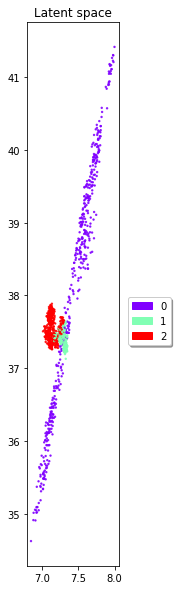

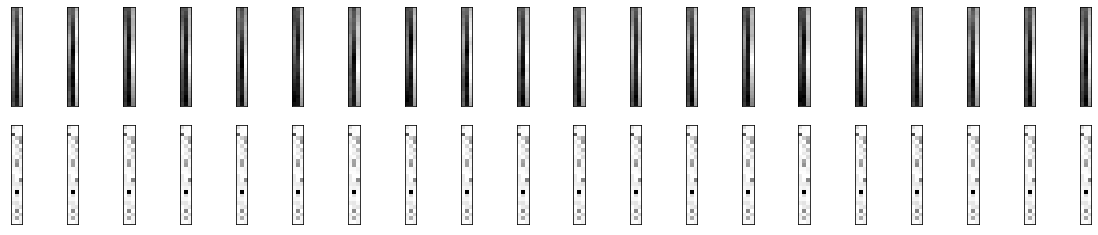

   1: TIME: 1.15 ETA: 113.58 AE_LOSS: 23.3080 DC_LOSS: 3.9857 DC_ACC: 0.6297 GEN_LOSS: 26.4359
   2: TIME: 1.28 ETA: 125.36 AE_LOSS: 23.1070 DC_LOSS: 5.8182 DC_ACC: 0.5832 GEN_LOSS: 71.5777
   3: TIME: 1.13 ETA: 110.09 AE_LOSS: 23.1087 DC_LOSS: 1.0383 DC_ACC: 0.5985 GEN_LOSS: 4.9545
   4: TIME: 1.28 ETA: 123.31 AE_LOSS: 23.1108 DC_LOSS: 1.1832 DC_ACC: 0.6250 GEN_LOSS: 1.7476
   5: TIME: 1.12 ETA: 106.10 AE_LOSS: 23.1008 DC_LOSS: 1.2429 DC_ACC: 0.6352 GEN_LOSS: 1.4332
   6: TIME: 1.29 ETA: 120.90 AE_LOSS: 23.1248 DC_LOSS: 1.5023 DC_ACC: 0.6279 GEN_LOSS: 0.7132
   7: TIME: 1.29 ETA: 119.56 AE_LOSS: 23.1175 DC_LOSS: 1.5749 DC_ACC: 0.6087 GEN_LOSS: 0.5507
   8: TIME: 1.28 ETA: 117.87 AE_LOSS: 23.1087 DC_LOSS: 1.5789 DC_ACC: 0.5901 GEN_LOSS: 0.5378
   9: TIME: 1.29 ETA: 117.23 AE_LOSS: 23.0746 DC_LOSS: 1.5591 DC_ACC: 0.5740 GEN_LOSS: 0.5422
  10: TIME: 1.13 ETA: 101.69 AE_LOSS: 23.0906 DC_LOSS: 1.5229 DC_ACC: 0.5630 GEN_LOSS: 0.5782


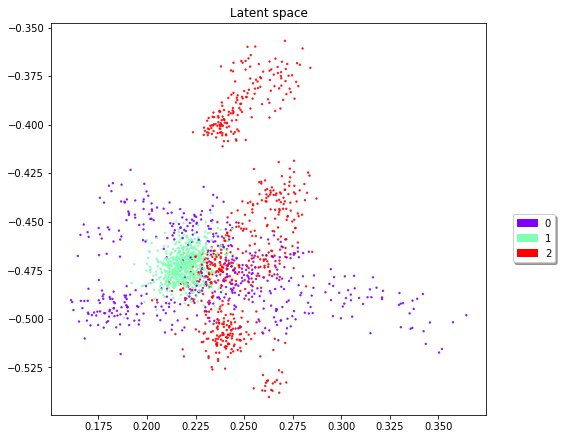

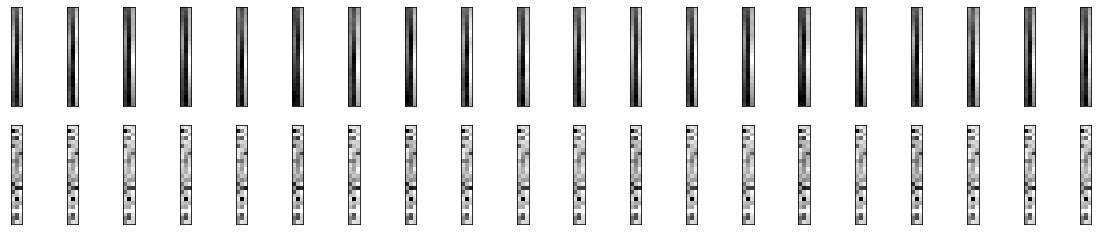

  11: TIME: 1.29 ETA: 115.18 AE_LOSS: 23.0795 DC_LOSS: 1.4913 DC_ACC: 0.5567 GEN_LOSS: 0.6051
  12: TIME: 1.14 ETA: 100.02 AE_LOSS: 23.0732 DC_LOSS: 1.4879 DC_ACC: 0.5518 GEN_LOSS: 0.6170
  13: TIME: 1.16 ETA: 100.86 AE_LOSS: 23.1106 DC_LOSS: 1.4713 DC_ACC: 0.5478 GEN_LOSS: 0.6408
  14: TIME: 1.16 ETA: 99.42 AE_LOSS: 23.0897 DC_LOSS: 1.4479 DC_ACC: 0.5445 GEN_LOSS: 0.6656
  15: TIME: 1.28 ETA: 109.07 AE_LOSS: 23.1037 DC_LOSS: 1.4371 DC_ACC: 0.5417 GEN_LOSS: 0.6774
  16: TIME: 1.28 ETA: 107.77 AE_LOSS: 23.0846 DC_LOSS: 1.4312 DC_ACC: 0.5391 GEN_LOSS: 0.6788
  17: TIME: 1.29 ETA: 106.83 AE_LOSS: 23.0971 DC_LOSS: 1.4208 DC_ACC: 0.5369 GEN_LOSS: 0.6867
  18: TIME: 1.11 ETA: 91.43 AE_LOSS: 23.1262 DC_LOSS: 1.4101 DC_ACC: 0.5349 GEN_LOSS: 0.6997
  19: TIME: 1.28 ETA: 103.73 AE_LOSS: 23.1017 DC_LOSS: 1.4067 DC_ACC: 0.5331 GEN_LOSS: 0.7020
  20: TIME: 1.29 ETA: 102.95 AE_LOSS: 23.0874 DC_LOSS: 1.4037 DC_ACC: 0.5315 GEN_LOSS: 0.6993


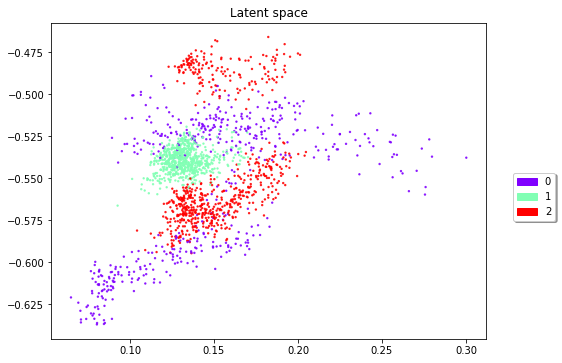

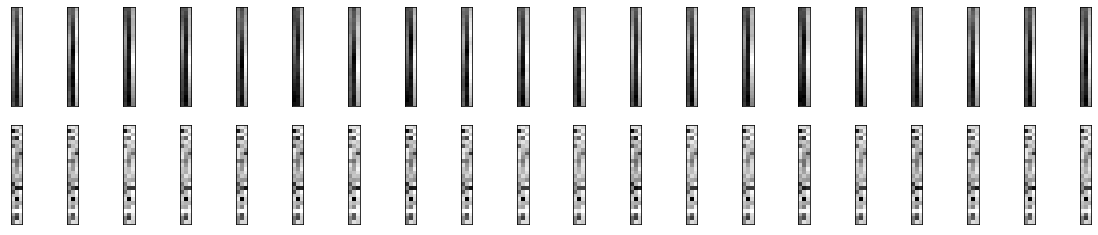

  21: TIME: 1.29 ETA: 101.55 AE_LOSS: 23.1134 DC_LOSS: 1.4002 DC_ACC: 0.5300 GEN_LOSS: 0.7024
  22: TIME: 1.29 ETA: 100.41 AE_LOSS: 23.1049 DC_LOSS: 1.3981 DC_ACC: 0.5287 GEN_LOSS: 0.7047
  23: TIME: 1.15 ETA: 88.87 AE_LOSS: 23.0955 DC_LOSS: 1.3947 DC_ACC: 0.5275 GEN_LOSS: 0.6792
  24: TIME: 1.28 ETA: 97.55 AE_LOSS: 23.0914 DC_LOSS: 1.3972 DC_ACC: 0.5264 GEN_LOSS: 0.6801
  25: TIME: 1.28 ETA: 96.32 AE_LOSS: 23.1517 DC_LOSS: 1.4167 DC_ACC: 0.5254 GEN_LOSS: 0.6975
  26: TIME: 1.29 ETA: 95.16 AE_LOSS: 23.0821 DC_LOSS: 1.4288 DC_ACC: 0.5243 GEN_LOSS: 0.6768
  27: TIME: 1.28 ETA: 93.76 AE_LOSS: 23.0998 DC_LOSS: 1.3993 DC_ACC: 0.5234 GEN_LOSS: 0.6658
  28: TIME: 1.28 ETA: 92.21 AE_LOSS: 23.0874 DC_LOSS: 1.4012 DC_ACC: 0.5227 GEN_LOSS: 0.6686
  29: TIME: 1.15 ETA: 81.93 AE_LOSS: 23.1036 DC_LOSS: 1.4079 DC_ACC: 0.5219 GEN_LOSS: 0.7026
  30: TIME: 1.29 ETA: 89.97 AE_LOSS: 23.0971 DC_LOSS: 1.4025 DC_ACC: 0.5212 GEN_LOSS: 0.6798


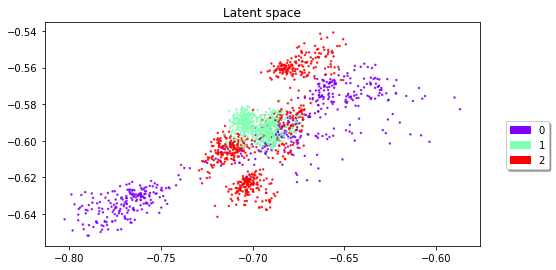

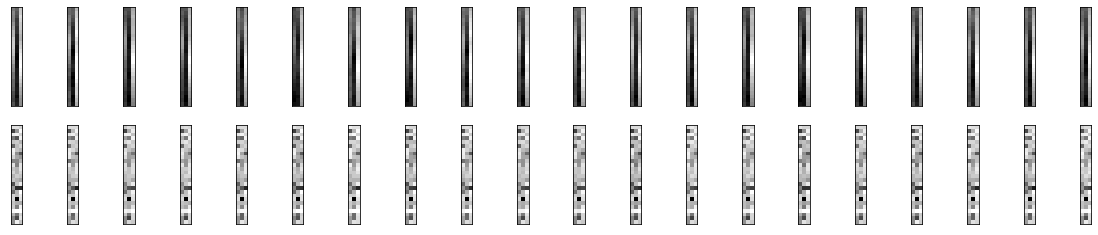

  31: TIME: 1.12 ETA: 77.40 AE_LOSS: 23.0921 DC_LOSS: 1.3800 DC_ACC: 0.5206 GEN_LOSS: 0.6772
  32: TIME: 1.28 ETA: 87.19 AE_LOSS: 23.0926 DC_LOSS: 1.3934 DC_ACC: 0.5202 GEN_LOSS: 0.6705
  33: TIME: 1.12 ETA: 75.26 AE_LOSS: 23.0959 DC_LOSS: 1.4234 DC_ACC: 0.5196 GEN_LOSS: 0.6812
  34: TIME: 1.28 ETA: 84.49 AE_LOSS: 23.1149 DC_LOSS: 1.4133 DC_ACC: 0.5190 GEN_LOSS: 0.6837
  35: TIME: 1.15 ETA: 74.77 AE_LOSS: 23.1182 DC_LOSS: 1.3864 DC_ACC: 0.5185 GEN_LOSS: 0.6868
  36: TIME: 1.14 ETA: 73.27 AE_LOSS: 23.0881 DC_LOSS: 1.3974 DC_ACC: 0.5180 GEN_LOSS: 0.6829
  37: TIME: 1.12 ETA: 70.74 AE_LOSS: 23.1237 DC_LOSS: 1.4106 DC_ACC: 0.5175 GEN_LOSS: 0.6987
  38: TIME: 1.28 ETA: 79.50 AE_LOSS: 23.0951 DC_LOSS: 1.4326 DC_ACC: 0.5171 GEN_LOSS: 0.6612
  39: TIME: 2.57 ETA: 156.96 AE_LOSS: 23.1055 DC_LOSS: 1.3570 DC_ACC: 0.5167 GEN_LOSS: 0.6954
  40: TIME: 2.64 ETA: 158.19 AE_LOSS: 23.0939 DC_LOSS: 1.3550 DC_ACC: 0.5163 GEN_LOSS: 0.6785


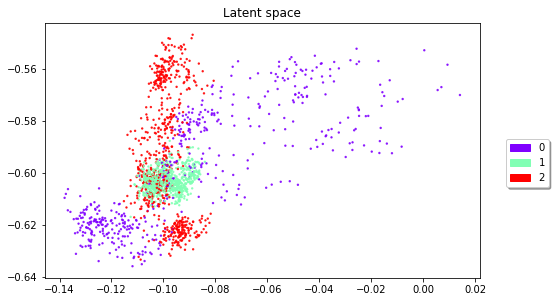

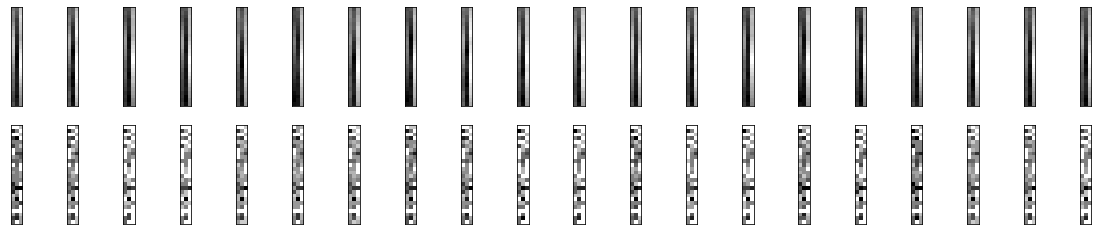

  41: TIME: 1.29 ETA: 76.06 AE_LOSS: 23.1245 DC_LOSS: 1.4523 DC_ACC: 0.5160 GEN_LOSS: 0.6496
  42: TIME: 1.55 ETA: 89.61 AE_LOSS: 23.0856 DC_LOSS: 1.4264 DC_ACC: 0.5155 GEN_LOSS: 0.6858
  43: TIME: 1.09 ETA: 61.89 AE_LOSS: 23.0989 DC_LOSS: 1.4042 DC_ACC: 0.5152 GEN_LOSS: 0.6897
  44: TIME: 1.28 ETA: 71.65 AE_LOSS: 23.1101 DC_LOSS: 1.3980 DC_ACC: 0.5148 GEN_LOSS: 0.6907
  45: TIME: 1.28 ETA: 70.39 AE_LOSS: 23.1020 DC_LOSS: 1.3984 DC_ACC: 0.5145 GEN_LOSS: 0.6890
  46: TIME: 1.28 ETA: 69.30 AE_LOSS: 23.1115 DC_LOSS: 1.4129 DC_ACC: 0.5142 GEN_LOSS: 0.6718
  47: TIME: 1.09 ETA: 57.77 AE_LOSS: 23.0974 DC_LOSS: 1.4202 DC_ACC: 0.5139 GEN_LOSS: 0.6982
  48: TIME: 1.13 ETA: 58.75 AE_LOSS: 23.0967 DC_LOSS: 1.4004 DC_ACC: 0.5136 GEN_LOSS: 0.7167
  49: TIME: 1.13 ETA: 57.45 AE_LOSS: 23.0964 DC_LOSS: 1.3971 DC_ACC: 0.5133 GEN_LOSS: 0.7149
  50: TIME: 1.28 ETA: 64.02 AE_LOSS: 23.1163 DC_LOSS: 1.4066 DC_ACC: 0.5131 GEN_LOSS: 0.6832


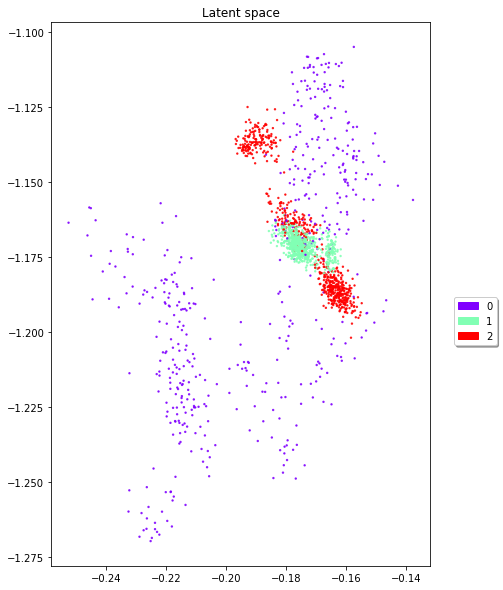

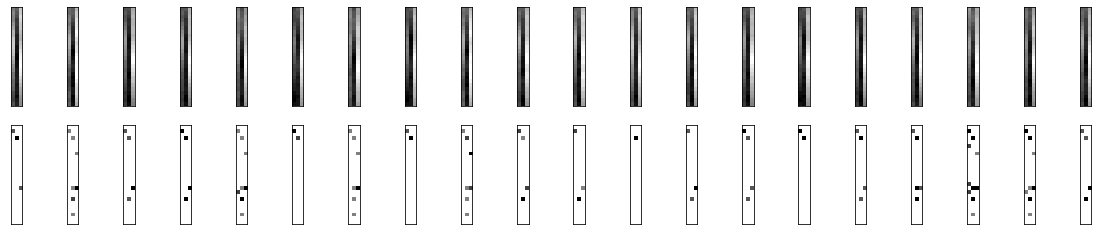

  51: TIME: 1.28 ETA: 62.96 AE_LOSS: 23.0890 DC_LOSS: 1.3952 DC_ACC: 0.5128 GEN_LOSS: 0.6720
  52: TIME: 1.29 ETA: 61.69 AE_LOSS: 23.1067 DC_LOSS: 1.3732 DC_ACC: 0.5126 GEN_LOSS: 0.6774
  53: TIME: 1.09 ETA: 51.46 AE_LOSS: 23.0875 DC_LOSS: 1.3854 DC_ACC: 0.5123 GEN_LOSS: 0.6872
  54: TIME: 1.17 ETA: 54.00 AE_LOSS: 23.0979 DC_LOSS: 1.4397 DC_ACC: 0.5121 GEN_LOSS: 0.6878
  55: TIME: 1.12 ETA: 50.50 AE_LOSS: 23.0964 DC_LOSS: 1.3811 DC_ACC: 0.5119 GEN_LOSS: 0.7126
  56: TIME: 1.29 ETA: 56.63 AE_LOSS: 23.1015 DC_LOSS: 1.3938 DC_ACC: 0.5117 GEN_LOSS: 0.7080
  57: TIME: 1.10 ETA: 47.45 AE_LOSS: 23.1016 DC_LOSS: 1.3997 DC_ACC: 0.5115 GEN_LOSS: 0.7015
  58: TIME: 1.28 ETA: 53.71 AE_LOSS: 23.1122 DC_LOSS: 1.3963 DC_ACC: 0.5113 GEN_LOSS: 0.6805
  59: TIME: 1.28 ETA: 52.63 AE_LOSS: 23.0917 DC_LOSS: 1.3836 DC_ACC: 0.5111 GEN_LOSS: 0.6745
  60: TIME: 1.13 ETA: 45.07 AE_LOSS: 23.1179 DC_LOSS: 1.3696 DC_ACC: 0.5109 GEN_LOSS: 0.6762


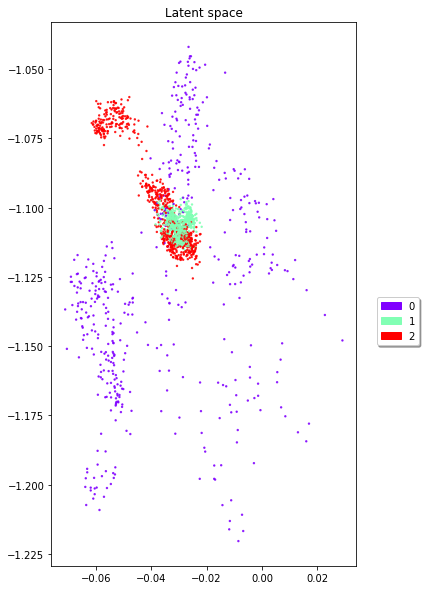

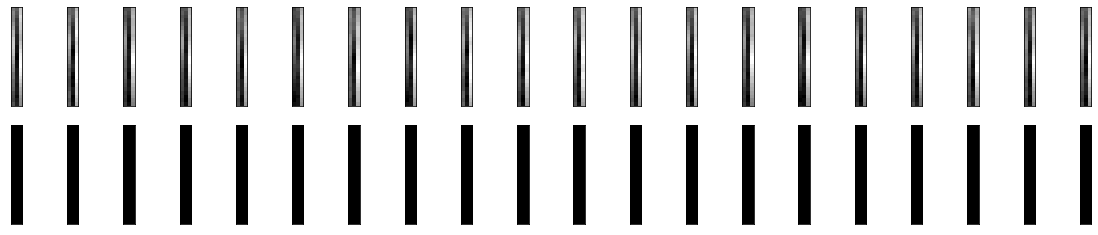

  61: TIME: 2.57 ETA: 100.18 AE_LOSS: 23.1018 DC_LOSS: 1.3835 DC_ACC: 0.5107 GEN_LOSS: 0.6878
  62: TIME: 1.12 ETA: 42.48 AE_LOSS: 23.0818 DC_LOSS: 1.4367 DC_ACC: 0.5106 GEN_LOSS: 0.6787
  63: TIME: 1.28 ETA: 47.46 AE_LOSS: 23.0968 DC_LOSS: 1.3962 DC_ACC: 0.5104 GEN_LOSS: 0.6977
  64: TIME: 1.29 ETA: 46.36 AE_LOSS: 23.1275 DC_LOSS: 1.3999 DC_ACC: 0.5102 GEN_LOSS: 0.7073
  65: TIME: 1.28 ETA: 44.89 AE_LOSS: 23.0900 DC_LOSS: 1.3894 DC_ACC: 0.5101 GEN_LOSS: 0.7062
  66: TIME: 1.08 ETA: 36.83 AE_LOSS: 23.0762 DC_LOSS: 1.3976 DC_ACC: 0.5099 GEN_LOSS: 0.6811
  67: TIME: 1.28 ETA: 42.23 AE_LOSS: 23.0826 DC_LOSS: 1.4059 DC_ACC: 0.5098 GEN_LOSS: 0.6552
  68: TIME: 1.08 ETA: 34.50 AE_LOSS: 23.1012 DC_LOSS: 1.3803 DC_ACC: 0.5096 GEN_LOSS: 0.6470
  69: TIME: 1.08 ETA: 33.59 AE_LOSS: 23.1108 DC_LOSS: 1.3914 DC_ACC: 0.5095 GEN_LOSS: 0.6953
  70: TIME: 1.07 ETA: 32.15 AE_LOSS: 23.1036 DC_LOSS: 1.4195 DC_ACC: 0.5094 GEN_LOSS: 0.7007


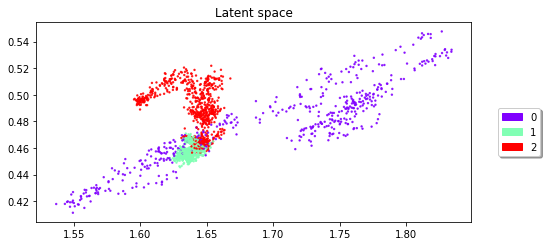

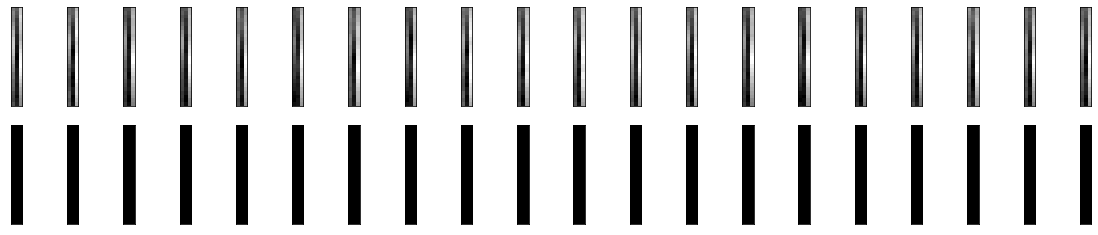

  71: TIME: 1.10 ETA: 31.97 AE_LOSS: 23.1081 DC_LOSS: 1.3734 DC_ACC: 0.5092 GEN_LOSS: 0.7080
  72: TIME: 1.29 ETA: 36.00 AE_LOSS: 23.1086 DC_LOSS: 1.3816 DC_ACC: 0.5091 GEN_LOSS: 0.7181
  73: TIME: 1.28 ETA: 34.67 AE_LOSS: 23.0829 DC_LOSS: 1.3962 DC_ACC: 0.5090 GEN_LOSS: 0.7114
  74: TIME: 2.57 ETA: 66.70 AE_LOSS: 23.1239 DC_LOSS: 1.3968 DC_ACC: 0.5089 GEN_LOSS: 0.6666
  75: TIME: 2.63 ETA: 65.63 AE_LOSS: 23.1153 DC_LOSS: 1.3707 DC_ACC: 0.5088 GEN_LOSS: 0.6566
  76: TIME: 1.28 ETA: 30.80 AE_LOSS: 23.1003 DC_LOSS: 1.3715 DC_ACC: 0.5087 GEN_LOSS: 0.6563
  77: TIME: 1.28 ETA: 29.54 AE_LOSS: 23.1081 DC_LOSS: 1.3908 DC_ACC: 0.5086 GEN_LOSS: 0.6636
  78: TIME: 1.29 ETA: 28.31 AE_LOSS: 23.1259 DC_LOSS: 1.4452 DC_ACC: 0.5085 GEN_LOSS: 0.6380
  79: TIME: 1.28 ETA: 26.98 AE_LOSS: 23.1174 DC_LOSS: 1.4019 DC_ACC: 0.5084 GEN_LOSS: 0.6987
  80: TIME: 1.12 ETA: 22.42 AE_LOSS: 23.1213 DC_LOSS: 1.3914 DC_ACC: 0.5082 GEN_LOSS: 0.7235


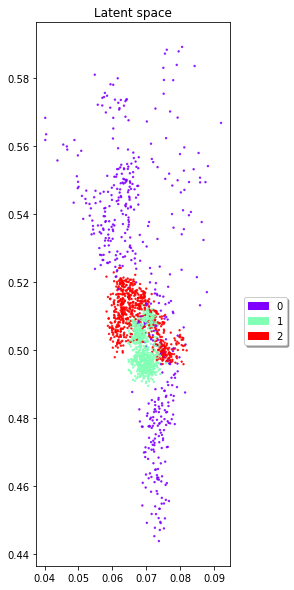

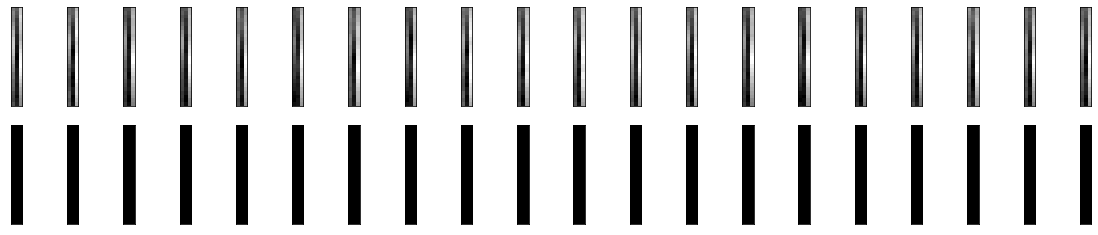

  81: TIME: 1.10 ETA: 20.87 AE_LOSS: 23.0993 DC_LOSS: 1.3938 DC_ACC: 0.5081 GEN_LOSS: 0.7185
  82: TIME: 1.28 ETA: 23.02 AE_LOSS: 23.1197 DC_LOSS: 1.4033 DC_ACC: 0.5080 GEN_LOSS: 0.6943
  83: TIME: 1.14 ETA: 19.41 AE_LOSS: 23.1161 DC_LOSS: 1.3885 DC_ACC: 0.5080 GEN_LOSS: 0.6846
  84: TIME: 1.28 ETA: 20.50 AE_LOSS: 23.0953 DC_LOSS: 1.3827 DC_ACC: 0.5079 GEN_LOSS: 0.6869
  85: TIME: 1.14 ETA: 17.04 AE_LOSS: 23.0866 DC_LOSS: 1.3866 DC_ACC: 0.5078 GEN_LOSS: 0.7069
  86: TIME: 1.14 ETA: 15.99 AE_LOSS: 23.1304 DC_LOSS: 1.3862 DC_ACC: 0.5077 GEN_LOSS: 0.7153
  87: TIME: 1.28 ETA: 16.67 AE_LOSS: 23.0804 DC_LOSS: 1.3753 DC_ACC: 0.5076 GEN_LOSS: 0.7246
  88: TIME: 1.28 ETA: 15.41 AE_LOSS: 23.0871 DC_LOSS: 1.4021 DC_ACC: 0.5075 GEN_LOSS: 0.7036
  89: TIME: 1.13 ETA: 12.40 AE_LOSS: 23.0922 DC_LOSS: 1.3911 DC_ACC: 0.5074 GEN_LOSS: 0.6707
  90: TIME: 1.13 ETA: 11.27 AE_LOSS: 23.0945 DC_LOSS: 1.4044 DC_ACC: 0.5074 GEN_LOSS: 0.6600


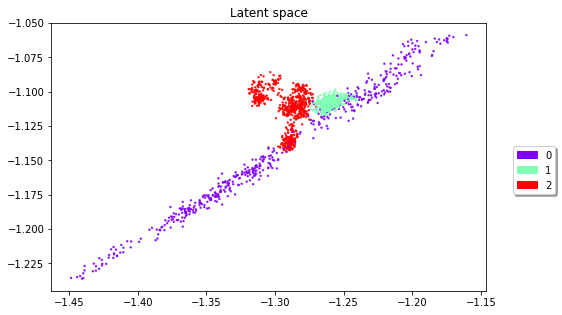

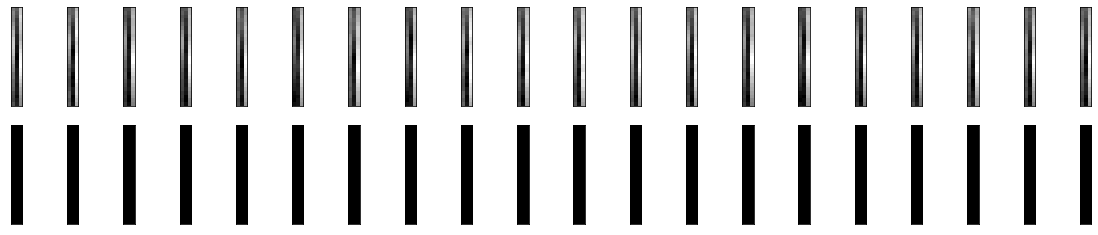

  91: TIME: 1.11 ETA: 10.00 AE_LOSS: 23.0961 DC_LOSS: 1.4294 DC_ACC: 0.5072 GEN_LOSS: 0.6092
  92: TIME: 1.18 ETA: 9.41 AE_LOSS: 23.0995 DC_LOSS: 1.3974 DC_ACC: 0.5072 GEN_LOSS: 0.6306
  93: TIME: 1.28 ETA: 8.99 AE_LOSS: 23.0994 DC_LOSS: 1.3893 DC_ACC: 0.5071 GEN_LOSS: 0.6831
  94: TIME: 1.16 ETA: 6.94 AE_LOSS: 23.1307 DC_LOSS: 1.4087 DC_ACC: 0.5070 GEN_LOSS: 0.7328
  95: TIME: 1.13 ETA: 5.64 AE_LOSS: 23.1106 DC_LOSS: 1.3893 DC_ACC: 0.5069 GEN_LOSS: 0.7541
  96: TIME: 1.08 ETA: 4.31 AE_LOSS: 23.1012 DC_LOSS: 1.3846 DC_ACC: 0.5069 GEN_LOSS: 0.7458
  97: TIME: 1.14 ETA: 3.42 AE_LOSS: 23.0899 DC_LOSS: 1.3866 DC_ACC: 0.5068 GEN_LOSS: 0.7221
  98: TIME: 1.15 ETA: 2.31 AE_LOSS: 23.0984 DC_LOSS: 1.4123 DC_ACC: 0.5067 GEN_LOSS: 0.6486
  99: TIME: 1.28 ETA: 1.28 AE_LOSS: 23.1098 DC_LOSS: 1.3770 DC_ACC: 0.5067 GEN_LOSS: 0.6360


In [12]:
from pathlib import Path
from matplotlib import gridspec
import matplotlib.patches as mpatches
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers.advanced_activations import LeakyReLU

# -------------------------------------------------------------------------------------------------------------
# Create models
img_shape = 78
latent_dim = 2
n_labels = 3 

def build_encoder():
    # Encoder
    input = Input(shape=(img_shape,))

    
    h = Dense(256)(input)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(256)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    encoded = Dense(latent_dim)(h)
    model = tf.keras.Model(inputs=input, outputs=encoded)
    return model

  
def build_decoder():

    encoded = Input(shape=(latent_dim + n_labels,))
    h = Dense(256)(encoded)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(256)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    reconstruction = Dense(img_shape, activation='sigmoid')(h)
    model = tf.keras.Model(inputs=encoded, outputs=reconstruction)
    return model


def build_discriminator():
    
    encoded = Input(shape=(latent_dim,))
    h = Dense(256)(encoded)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(256)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    prediction = Dense(1)(h)
    model = tf.keras.Model(inputs=encoded, outputs=prediction)
    return model


encoder = build_encoder()
decoder = build_decoder()
discriminator = build_discriminator()
  # -------------------------------------------------------------------------------------------------------------
# Define loss functions

ae_loss_weight = 1.
gen_loss_weight = 1.
dc_loss_weight = 1.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()


def autoencoder_loss(inputs, reconstruction, loss_weight):
    return loss_weight * mse(inputs, reconstruction)
  

def discriminator_loss(real_output, fake_output, loss_weight):
    loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output), logits=real_output))
    loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_output), logits=fake_output))
    return loss_fake + loss_real

def generator_loss(fake_output, loss_weight):
    g_loss =tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_output), logits=fake_output))
    return g_loss
# -------------------------------------------------------------------------------------------------------------
# Define cyclic learning rate
base_lr = 0.00025
max_lr = 0.0025

n_samples = train.shape[0]
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0

# -------------------------------------------------------------------------------------------------------------
# Define optimizers
ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
  # -------------------------------------------------------------------------------------------------------------
# Training function
@tf.function
def train_step(batch_x, batch_y):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(tf.concat([encoder_output, tf.one_hot(batch_y, n_labels)], axis=1), training=True)

        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, decoder_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, encoder.trainable_variables + decoder.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], latent_dim], mean=0.0, stddev=1.0)
        encoder_output = encoder(batch_x, training=True)

        dc_real = discriminator(real_distribution, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, discriminator.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, discriminator.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = encoder(batch_x, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss = generator_loss(dc_fake, 1)

    gen_grads = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss

# -------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 100
aeloss = []
dcloss = []
genloss = []

for epoch in range(n_epochs):
      start = time.time()

      epoch_ae_loss_avg = tf.metrics.Mean()
      epoch_dc_loss_avg = tf.metrics.Mean()
      epoch_dc_acc_avg = tf.metrics.Mean()
      epoch_gen_loss_avg = tf.metrics.Mean()

      for batch, (batch_x, batch_y) in enumerate(train_dataset):
      # -------------------------------------------------------------------------------------------------------------
        # Calculate cyclic learning rate
          global_step = global_step + 1
          cycle = np.floor(1 + global_step / (2 * step_size))
          x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
          clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
          ae_optimizer.lr = clr
          dc_optimizer.lr = clr
          gen_optimizer.lr = clr

          ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x, batch_y)

          epoch_ae_loss_avg(ae_loss)
          epoch_dc_loss_avg(dc_loss)
          epoch_dc_acc_avg(dc_acc)
          epoch_gen_loss_avg(gen_loss)


      dcloss.append(epoch_dc_loss_avg.result())
      genloss.append(epoch_gen_loss_avg.result())
      aeloss.append(epoch_ae_loss_avg.result())
      epoch_time = time.time() - start
      print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
      
  

   # -------------------------------------------------------------------------------------------------------------
      if epoch % 10 == 0:
        # Latent space of test set
        x_test_encoded = encoder(test, training=False)
        label_list = list(y_test)
        fig = plt.figure(figsize=(10, 10))
        classes = set(label_list)
        colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
        kwargs = {'alpha': 0.8, 'c': [colormap[i] for i in label_list]}
        ax = plt.subplot(111, aspect='equal')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
                   for i, class_ in enumerate(classes)]
        ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
                  fancybox=True, loc='center left')
        plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], s=2, **kwargs)
        #ax.set_xlim([-3, 3])
        #ax.set_ylim([-3, 3])
        plt.title("Latent space")
        plt.show()

        #plt.savefig(latent_space_dir / ('epoch_%d.png' % epoch))
        #plt.close('all')

        # Reconstruction
        n_digits = 20  # how many digits we will display
        x_test_decoded = decoder(
            tf.concat([x_test_encoded[:n_digits], tf.one_hot(y_test[:n_digits], n_labels)], axis=1), training=False)

        x_test_decoded = np.reshape(x_test_decoded, [-1, 26, 3])*255
        fig = plt.figure(figsize=(20, 4))
        for i in range(n_digits):
            # display original
            ax = plt.subplot(2, n_digits, i + 1)
            plt.imshow(test[i].reshape(26, 3))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(x_test_decoded[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        plt.show()

       # plt.savefig(reconstruction_dir / ('epoch_%d.png' % epoch))
       # plt.close('all')


In [ ]:
from re import X
topology_file = '/content/drive/MyDrive/for_tongfei/CA_only.pdb'
outpath = '/content/drive/MyDrive/for_tongfei/test.pdb'
x_test_encoded = encoder(test, training=False)
x_test_decoded = decoder(
            tf.concat([x_test_encoded[:300], tf.one_hot(y_test[:300], n_labels)], axis=1), training=False)

x_test_decoded = np.reshape(x_test_decoded, [-1, 26, 3])
pdb_data = np.stack(x_test_decoded[10:15])
save_pdb(pdb_data, topology_file, outpath)

<mdtraj.Topology with 1 chains, 26 residues, 26 atoms, 0 bonds>
<mdtraj.Trajectory with 5 frames, 26 atoms, 26 residues, without unitcells>


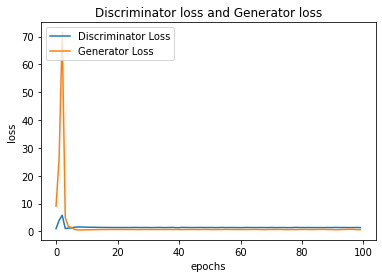

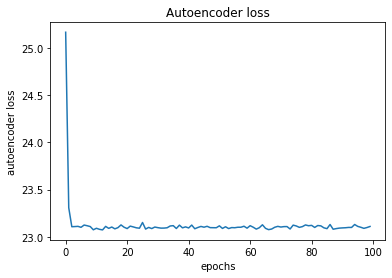

In [13]:
t = np.arange(0, n_epochs, 1)
plt.title("Discriminator loss and Generator loss")
plt.plot(t, dcloss)
plt.plot(t, genloss)  
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['Discriminator Loss', 'Generator Loss'], loc = 'upper left')
plt.show()

plt.title("Autoencoder loss")
plt.plot(t, aeloss)
plt.xlabel("epochs")
plt.ylabel("autoencoder loss")
plt.show()


Plot the loss VS. the latent dimension 

In [ ]:
from pathlib import Path
from matplotlib import gridspec
import matplotlib.patches as mpatches
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers.advanced_activations import LeakyReLU

# -------------------------------------------------------------------------------------------------------------
# Create models
img_shape = 78
latent_dim = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
n_labels = 3 
avg_dcloss =[]
avg_genloss = []
for ld in range(len(latent_dim)):
  def build_encoder():
    # Encoder
    input = Input(shape=(img_shape,))

    
    h = Dense(256)(input)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(256)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    encoded = Dense(latent_dim[ld])(h)
    model = tf.keras.Model(inputs=input, outputs=encoded)
    return model

  
  def build_decoder():

    encoded = Input(shape=(latent_dim[ld] + n_labels,))
    h = Dense(256)(encoded)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(256)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    reconstruction = Dense(img_shape, activation='sigmoid')(h)
    model = tf.keras.Model(inputs=encoded, outputs=reconstruction)
    return model


  def build_discriminator():
    
    encoded = Input(shape=(latent_dim[ld],))
    h = Dense(256)(encoded)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(256)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    prediction = Dense(1)(h)
    model = tf.keras.Model(inputs=encoded, outputs=prediction)
    return model


  encoder = build_encoder()
  decoder = build_decoder()


  discriminator = build_discriminator()
  # -------------------------------------------------------------------------------------------------------------
# Define loss functions

  ae_loss_weight = 1.
  gen_loss_weight = 1.
  dc_loss_weight = 1.

  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  mse = tf.keras.losses.MeanSquaredError()
  accuracy = tf.keras.metrics.BinaryAccuracy()


  def autoencoder_loss(inputs, reconstruction, loss_weight):
      return loss_weight * mse(inputs, reconstruction)


  def discriminator_loss(real_output, fake_output, loss_weight):
     print(real_output.shape, tf.ones_like(real_output))
     loss_real = cross_entropy(tf.ones_like(real_output), real_output)
     loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
     return loss_weight * (loss_fake + loss_real)


  def generator_loss(fake_output, loss_weight):
      return loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)

# -------------------------------------------------------------------------------------------------------------
# Define cyclic learning rate
  base_lr = 0.00025
  max_lr = 0.0025

  n_samples = train.shape[0]
  step_size = 2 * np.ceil(n_samples / batch_size)
  global_step = 0

# -------------------------------------------------------------------------------------------------------------
# Define optimizers
  ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
  dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
  gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
  # -------------------------------------------------------------------------------------------------------------
# Training function
  @tf.function
  def train_step(batch_x, batch_y):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(tf.concat([encoder_output, tf.one_hot(batch_y, n_labels)], axis=1), training=True)

        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, decoder_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, encoder.trainable_variables + decoder.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], latent_dim[ld]], mean=0.0, stddev=1.0)
        encoder_output = encoder(batch_x, training=True)

        dc_real = discriminator(real_distribution, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, discriminator.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, discriminator.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = encoder(batch_x, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss = generator_loss(dc_fake, 1)

    gen_grads = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss

# -------------------------------------------------------------------------------------------------------------
# Training loop
  n_epochs = 20
  dcloss = []
  genloss = []
  
  for epoch in range(n_epochs):
      start = time.time()

      epoch_ae_loss_avg = tf.metrics.Mean()
      epoch_dc_loss_avg = tf.metrics.Mean()
      epoch_dc_acc_avg = tf.metrics.Mean()
      epoch_gen_loss_avg = tf.metrics.Mean()

      for batch, (batch_x, batch_y) in enumerate(train_dataset):
      # -------------------------------------------------------------------------------------------------------------
        # Calculate cyclic learning rate
          global_step = global_step + 1
          cycle = np.floor(1 + global_step / (2 * step_size))
          x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
          clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
          ae_optimizer.lr = clr
          dc_optimizer.lr = clr
          gen_optimizer.lr = clr

          ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x, batch_y)

          epoch_ae_loss_avg(ae_loss)
          epoch_dc_loss_avg(dc_loss)
          epoch_dc_acc_avg(dc_acc)
          epoch_gen_loss_avg(gen_loss)


      dcloss.append(epoch_dc_loss_avg.result())
      genloss.append(epoch_gen_loss_avg.result())
      epoch_time = time.time() - start
      print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
  avg_dcloss.append(dcloss[-1])
  avg_genloss.append(genloss[-1])


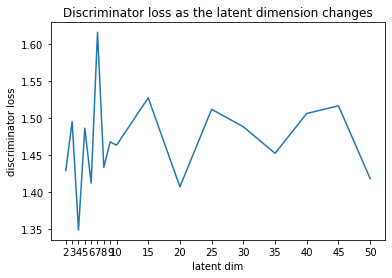

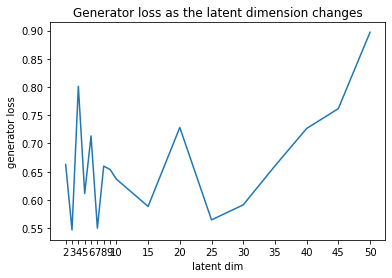

In [ ]:
plt.title("Discriminator loss as the latent dimension changes")
plt.plot(latent_dim, avg_dcloss) 
plt.xticks(latent_dim) 
plt.xlabel("latent dim")
plt.ylabel("discriminator loss")
plt.show()

plt.title("Generator loss as the latent dimension changes")
plt.plot(latent_dim, avg_genloss) 
plt.xticks(latent_dim) 
plt.xlabel("latent dim")
plt.ylabel("generator loss")
plt.show()

Use the TSNE to plot the data

In [ ]:
from sklearn.manifold import TSNE
x_test_decoded = decoder(
            tf.concat([x_test_encoded, tf.one_hot(y_test, n_labels)], axis=1), training=False)

tsne = TSNE(random_state=42)
fitted = tsne.fit_transform(x_test_decoded)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


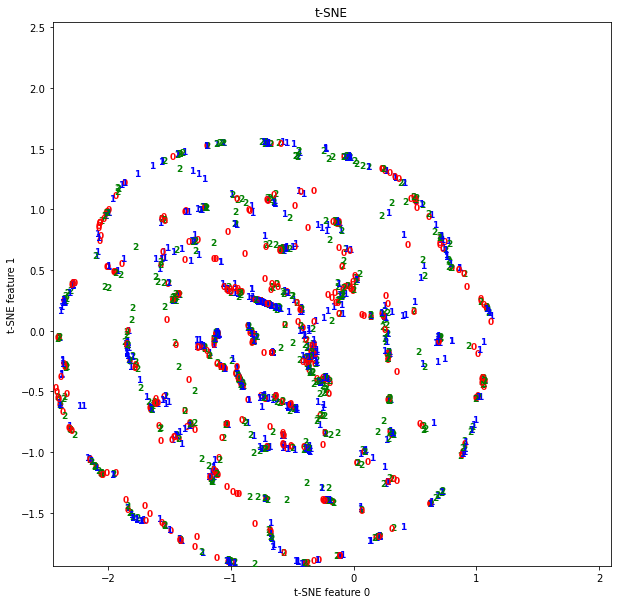

In [ ]:
colors = ['r', 'b', 'g']
plt.figure(figsize=(10, 10))
plt.xlim(fitted[:,0].min(), fitted[:,0].max()+1)
plt.ylim(fitted[:,1].min(), fitted[:,1].max()+1)
for i in range(len(test)):
    plt.text(fitted[i,0], fitted[i,1], str(y_test[i]), color=colors[y_test[i]], 
           fontdict={'weight':'bold', 'size':9})
    plt.title('t-SNE')
    plt.xlabel('t-SNE feature 0')
    plt.ylabel('t-SNE feature 1')